In [1]:
import scipy
import scipy.io
import scipy.ndimage
import numpy as np
import xarray as xr
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.linalg import block_diag

import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import pickle
from functools import partial

# from NeuralNet import *
from timeit import default_timer

from Solver import *
import sys
sys.path.append('../Utility')

import PlotDefault
import NeuralNet
import KalmanInversion 
from Numerics import gradient_fft

# from functools import partial

# sys.path.append('../Utility')
# from Numerics import gradient_first,  gradient_first_c2f, gradient_first_f2c, interpolate_c2f, interpolate_f2c, psi_fft_sol, gradient_fft
# import NeuralNet
# import PlotDefault

In [2]:
beta_rek_strs = [("1", "0p3"), ("2", "0p3"), ("3", "0p3"), ("1", "0p6"), ("2", "0p6"), ("3", "0p6")]

beta_reks = [ (str_to_num(beta_rek_strs[i][0]), str_to_num(beta_rek_strs[i][1])) for i in range(len(beta_rek_strs)) ]
physics_params, q_mean, psi_mean, dpv_mean,  mu_mean, mu_mean_clip,  closure_mean, yy, force = load_data(beta_rek_strs = beta_rek_strs, beta_reks = beta_reks)

# Load Model

In [3]:
TRAINING_TYPE = "indirect" # indirect   indirect_res

if TRAINING_TYPE == "direct":
    print("load direct nn")
    trained_net = torch.load("direct.nn")
else:
    (save_folder, uki_iter) = ("indirect_NN_Flux" , 40) if TRAINING_TYPE=="indirect" else ("indirect_NN_res" , 99)
    uki_file = save_folder + "/ukiobj-" + str(uki_iter) + ".dat"
    print(uki_file)
    uki_obj = pickle.load( open(uki_file , "rb" ) )
    trained_net = NeuralNet.create_net(ind, outd, layers, width, activation, initializer, outputlayer, uki_obj.theta_mean[-1])

    
# print(trained_net.modus['LinM{}'.format(1)].weight)
# print(trained_net.modus['LinM{}'.format(1)].bias)
print(trained_net.modus['LinMout'].weight)
print(trained_net.modus['LinMout'].bias)

indirect_NN_Flux/ukiobj-40.dat
Parameter containing:
tensor([[-0.5972, -1.8552, -0.4051,  0.7822, -0.1571, -0.3729,  1.7831,  1.6546,
         -0.7510,  0.1910]], requires_grad=True)
Parameter containing:
tensor([0.5219], requires_grad=True)


# Direct Test

../Utility/NeuralNet.py:504: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = net(torch.tensor(x, dtype=torch.float32)).detach().numpy().flatten()
/home/dzhuang/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


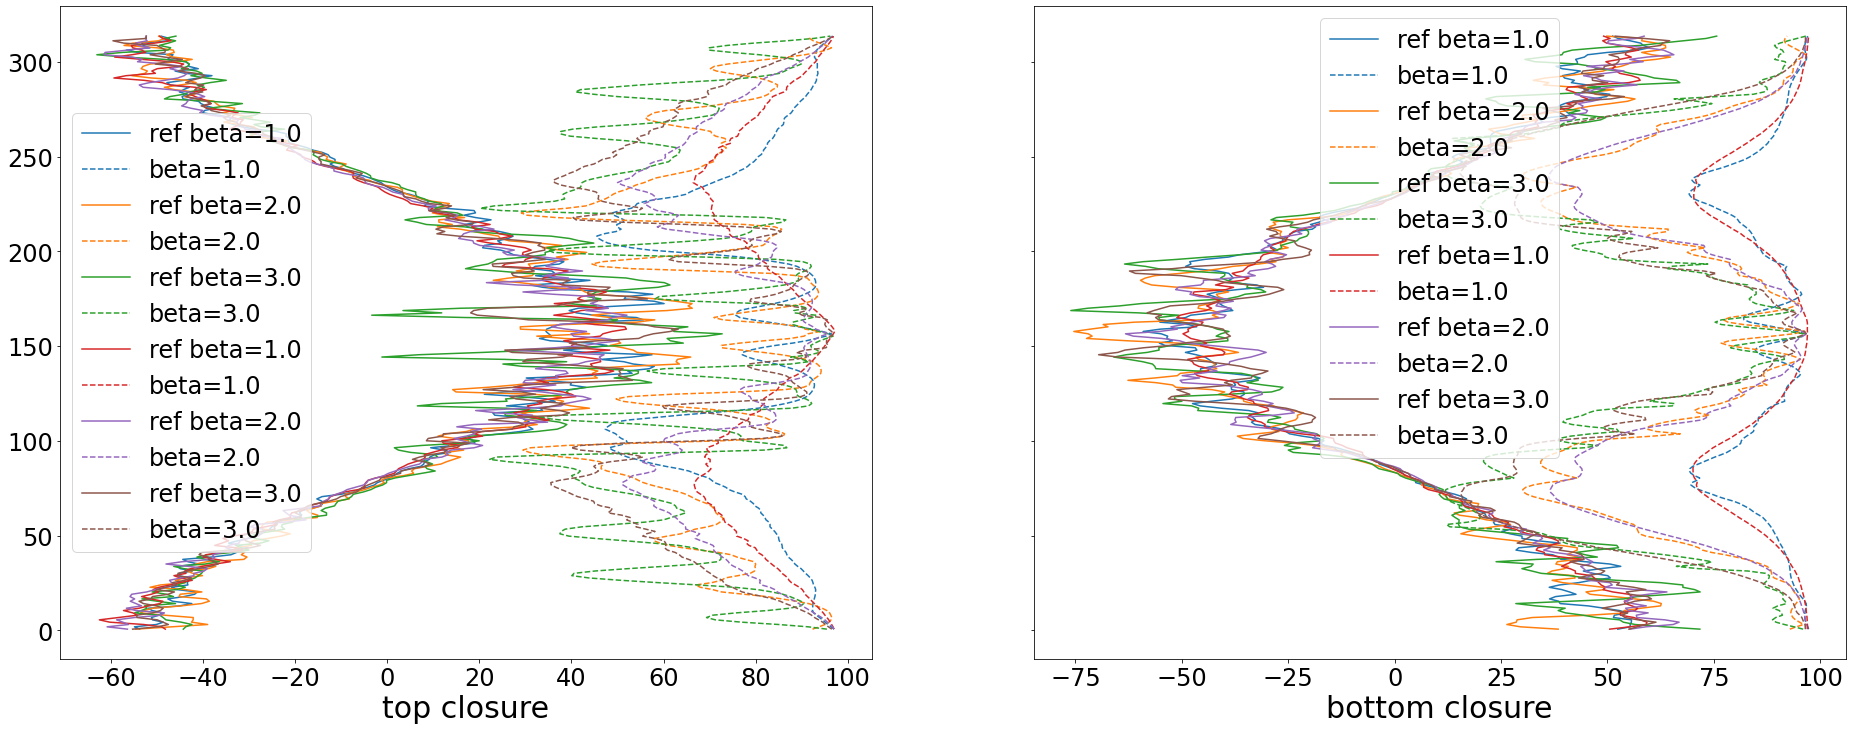

In [4]:
N_data = len(beta_reks)

# x_train = torch.from_numpy(np.reshape(dpv_mean.flatten()/dpv_scale, (-1,1)).astype(np.float32))
# x_train = torch.from_numpy(np.stack((dpv_mean.flatten()/dpv_scale, np.fabs(psi_mean).flatten()/psi_scale)).T.astype(np.float32)) 

x_train = torch.from_numpy(np.stack((np.fabs(q_mean).flatten()/q_scale, dpv_mean.flatten()/dpv_scale, np.fabs(psi_mean).flatten()/psi_scale)).T.astype(np.float32)) 
flux_pred = NeuralNet.net_eval(x=x_train, net=trained_net, mu_scale = flux_scale, non_negative=False, filter_on=False, filter_sigma=filter_sigma, n_data=2*N_data).reshape((N_data, 2, -1))


fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(32,12))
for i in range(N_data):
    ax[0].plot(closure_mean[i,0, :], yy, "-", color="C"+str(i), label="ref beta="+str(beta_reks[i][0]))
    ax[1].plot(closure_mean[i,1, :], yy, "-", color="C"+str(i), label="ref beta="+str(beta_reks[i][0]))
    
    
    ax[0].plot(flux_pred[i,0, :], yy, "--", color="C"+str(i), label="beta="+str(beta_reks[i][0]))
    ax[1].plot(flux_pred[i,1, :], yy, "--", color="C"+str(i), label="beta="+str(beta_reks[i][0]))
    
    
ax[0].set_xlabel("top closure")
ax[1].set_xlabel("bottom closure")


for i in range(2):
    ax[i].legend()

fig.savefig("QG-Training-" + TRAINING_TYPE + "-Direct-Test.png")

In [5]:
np.fabs(psi_mean).flatten()/psi_scale

array([0.03657327, 0.14867498, 0.26019077, ..., 0.00453807, 0.02020597,
       0.03017704])

In [6]:
# 2D plot 

In [7]:
N_test_1d = 400
Lx_test_1d = 20
Ly_test_1d = 400
N_test = N_test_1d**2

x1_test_1d = np.linspace(-Lx_test_1d, Lx_test_1d, N_test_1d)
x2_test_1d = np.linspace(-Ly_test_1d, Ly_test_1d, N_test_1d)
X_test_2d, Y_test_2d = np.meshgrid(x1_test_1d, x2_test_1d)

x_test = np.vstack((np.abs(X_test_2d.reshape(-1))/dpv_scale, Y_test_2d.reshape(-1)/psi_scale)).T    


y_pred = NeuralNet.net_eval(net=trained_net, x=x_test, mu_scale=mu_scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma, n_data=N_test_1d)  

y_pred_2d = y_pred.reshape((N_test_1d,N_test_1d))


fig, ax = plt.subplots(ncols=2, sharex=False,sharey=False, nrows=1, figsize=((16,6)))

im1=ax[0].pcolormesh(X_test_2d, Y_test_2d, y_pred_2d, shading="gouraud")
fig.colorbar(im1, ax=ax[0])
ax[0].set_title("Prediction")
ax[0].set_xlabel("dpv")
ax[0].set_ylabel("psi")


for i in range(N_data):
    ax[1].plot(dpv_mean[i, 0, :], np.fabs(psi_mean[i,0,:]),  "--o", color = "black", fillstyle="none")
    ax[1].plot(dpv_mean[i, 1, :], np.fabs(psi_mean[i,1,:]),   "--o", color = "black", fillstyle="none")

ax[1].set_title("Training Data")
ax[1].set_xlabel("dpv")
ax[1].set_ylabel("psi")



    
fig.subplots_adjust(bottom=0.15,top=0.92,left=0.08,right=0.97)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (160000x2 and 3x10)

In [14]:
def Qg(params, trained_net, force):
    
#     beta  =params["beta"]
    
#     # reference
#     folder_name = "/central/groups/esm/dzhuang/pyqg_run/2layer/nx256beta" + str(beta) + "rek0p3/"
#     file_name = "nx256beta" + str(beta) + "rek0p3"
#     start, end, step = 500000, 1000000, 20000

#     flow_means_ref, _ = preprocess_data(folder_name, file_name, beta, dU, L, start, end, step)
#     mu_mean_ref, dpv_mean_ref, u_mean_ref, vor_mean_ref, q_mean_ref, psi_mean_ref, flux_mean_ref, psi_var_2_mean_ref = flow_means_ref[:8]

    
    dt = 4e-3
    save_every = 1000
    Nt = 400000 

    
    Ny = force.shape[1]
    
    # q0 = np.copy(q_mean)
    q0 = np.zeros((2, Ny))
    yy, dy = np.linspace(L/(2*Ny), L - L/(2*Ny), Ny), L/Ny

    q0[0, :] = -params.beta*L/2 * np.sin(2*np.pi*yy/L)
    q0[1, :] =  params.beta*L/2* np.sin(2*np.pi*yy/L)
    
    beta1 = beta2 = params.beta
    
    
        
    nn_model = partial(NeuralNet.nn_viscosity, net=trained_net, mu_scale = mu_scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma)
    model = lambda q, psi, xx, res, k2, dealiasing_filter : nummodel_flux_fft(nn_model, beta1, beta2,  q, psi, xx, res, k2, dealiasing_filter)
    
#     model = lambda q, psi, xx, res, k2, dealiasing_filter : nummodel_fft(nn_model, beta1, beta2,  q, psi, xx, res, k2, dealiasing_filter)
    yy, t_data, q_data = explicit_solve(model, force, q0, params, dt = dt, Nt = Nt, save_every = save_every)
    
    q_mean_pred = np.mean(q_data[Nt//(2*save_every):, :, :], axis=0)
    
    return yy, q_mean_pred, q_data 

Ny = 256
L = 50*2*np.pi
H = [1.0, 1.0]               # the rest depths of each layer
kd = 1.0                     # rd

U = [0.0, 0.0]
dU = U[0] - U[1] 
F1 = kd/(1 + (H[0]/H[1])**2.0)
F2 = kd/(1 + (H[1]/H[0])**2.0)
hyper_nu, hyper_order = 0.0, 2
Q = 1.0
yy, dy = np.linspace(L/(2*Ny), L - L/(2*Ny), Ny), L/Ny

force = np.zeros((2, Ny))
force[0, :] = -Q * np.sin(2*np.pi*yy/L)
force[1, :] =  Q * np.sin(2*np.pi*yy/L)   
    
test_ind = 1
q_mean_ref = q_mean[test_ind, :, :]
dpv_mean_ref = dpv_mean[test_ind, :, :]
# test with betas[test_ind]
params = QG_params(L=L, dU=dU, F1=F1, F2=F2, hyper_nu=hyper_nu, hyper_order=hyper_order, beta=beta_reks[test_ind][0], rek=beta_reks[test_ind][1])


yy, q_mean_pred, q_data  = Qg( params , trained_net, force)




/home/dzhuang/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


200000 max q 965.3934009935306
400000 max q 1685.7334742512915


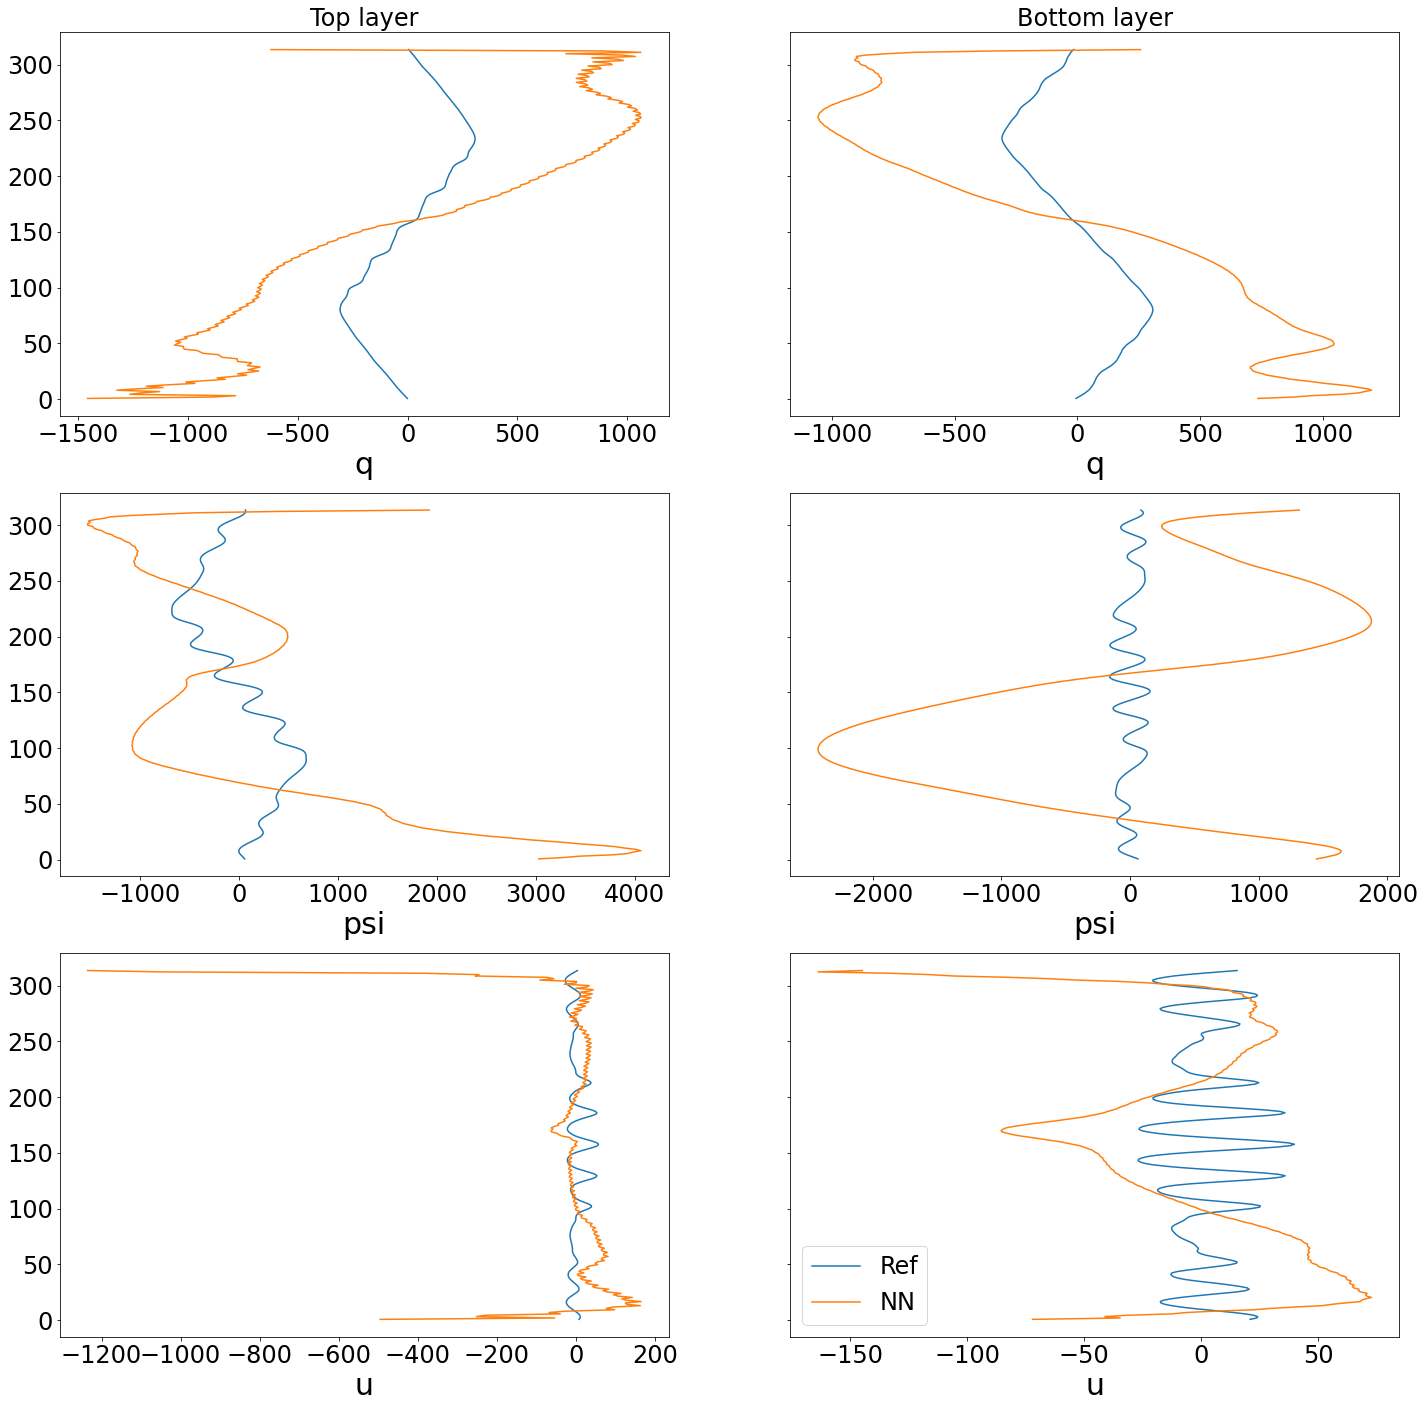

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=True, figsize=(24,24))


ax[0,0].plot(q_mean_ref[0, : ], yy,   label="Ref")                                                                         
ax[0,0].plot(q_mean_pred[0, : ], yy, label="NN")
ax[0,1].plot(q_mean_ref[1, : ] , yy,   label="Ref")                                                                         
ax[0,1].plot(q_mean_pred[1, : ], yy, label="NN")
ax[0,0].set_xlabel("q")
ax[0,1].set_xlabel("q")


# compute psi
k2, dealiasing_filter = precomp_fft(Ny)
psi_mean_ref = psi_mean[test_ind, :, :] # psi_fft_sol(q_mean_ref, F1, F2, dy, k2, dealiasing_filter)
psi_mean_pred = psi_fft_sol(q_mean_pred, F1, F2, dy, k2, dealiasing_filter)

ax[1,0].plot(psi_mean_ref[0, : ], yy,   label="Ref")                                                                         
ax[1,0].plot(psi_mean_pred[0, : ], yy, label="NN")
ax[1,1].plot(psi_mean_ref[1, : ] , yy,   label="Ref")                                                                         
ax[1,1].plot(psi_mean_pred[1, : ], yy, label="NN")
ax[1,0].set_xlabel("psi")
ax[1,1].set_xlabel("psi")


# compute U velocity
k2, dealiasing_filter = precomp_fft(Ny)
u_mean_ref = np.copy(psi_mean_ref)
u_mean_pred = np.copy(psi_mean_pred)
for i in range(2):
    u_mean_ref[i,:] = -gradient_fft(psi_mean_ref[i,:], dy, 1, k2, dealiasing_filter)
    u_mean_pred[i,:] = -gradient_fft(psi_mean_pred[i,:], dy, 1, k2, dealiasing_filter)

ax[2,0].plot(u_mean_ref[0, : ], yy,   label="Ref")                                                                         
ax[2,0].plot(u_mean_pred[0, : ], yy, label="NN")
ax[2,1].plot(u_mean_ref[1, : ] , yy,   label="Ref")                                                                         
ax[2,1].plot(u_mean_pred[1, : ], yy, label="NN")
ax[2,0].set_xlabel("u")
ax[2,1].set_xlabel("u")


ax[0,0].set_title("Top layer")
ax[0,1].set_title("Bottom layer")

plt.legend()
fig.savefig("QG-Training-" + TRAINING_TYPE + "-Indirect-Test.png")

In [20]:
N_runs = len(beta_reks) 
start, end, step = 500000, 1000000, 20000
file_names = ["nx256beta" + beta_rek_strs[i][0] + "rek" + beta_rek_strs[i][1]  for i in range(N_runs)] 
folder_names = ["/central/groups/esm/zhaoyi/pyqg_run/2layer/inhomogeneous/" + file_names[i] + "/" for i in range(N_runs)]

i = test_ind
flow_means, flow_zonal_means = preprocess_data(folder_names[i], file_names[i], beta_reks[i][0], dU, L, start, end, step)
u_mean_ = flow_means[2]

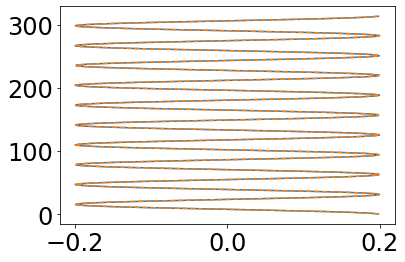

In [21]:
Ny = 256
L = 50*2*np.pi
k2, dealiasing_filter = precomp_fft(Ny)
yy, dy = np.linspace(L/(2*Ny), L - L/(2*Ny), Ny), L/Ny

f = np.sin(10*2*np.pi*yy/L)
df = 10*2*np.pi*np.cos(10*2*np.pi*yy/L)/L
df_pred = gradient_fft(f, dy, 1, k2, dealiasing_filter)

plt.plot(df, yy, "-")
plt.plot(df_pred, yy, "--")

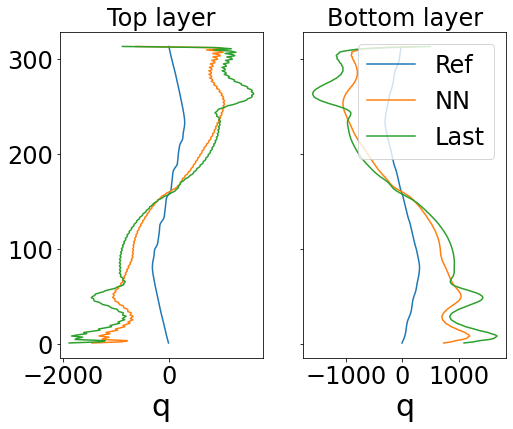

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(8,6))


ax[0].plot(q_mean_ref[0, : ], yy,   label="Ref")                                                                         
ax[0].plot(q_mean_pred[0, : ], yy, label="NN")
ax[0].plot(q_data[-1, 0, :], yy, label="Last")
ax[1].plot(q_mean_ref[1, : ] , yy,   label="Ref")                                                                         
ax[1].plot(q_mean_pred[1, : ], yy, label="NN")
ax[1].plot(q_data[-1, 1, :], yy, label="Last")
ax[0].set_xlabel("q")
ax[1].set_xlabel("q")

ax[0].set_title("Top layer")
ax[1].set_title("Bottom layer")

plt.legend()
fig.savefig("QG-Training-" + TRAINING_TYPE + "-Indirect-Test.png")

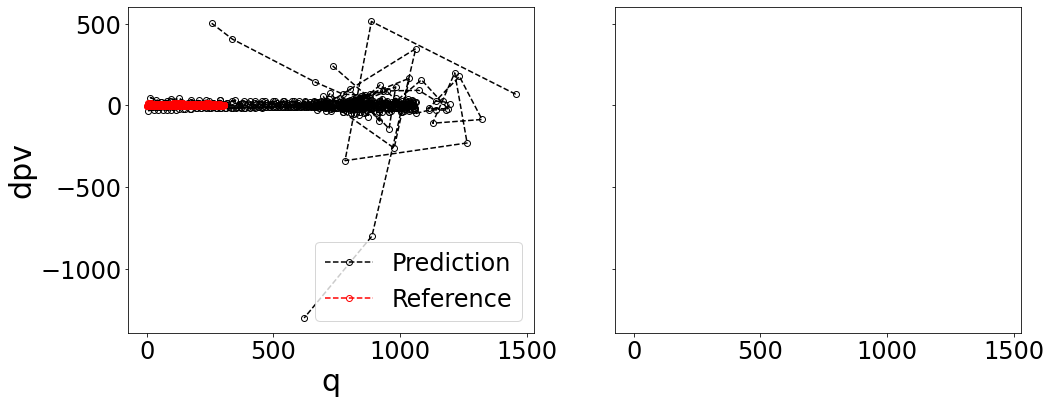

In [23]:
dpv_mean_pred = np.copy(q_mean_pred)
dpv_mean_pred[0, :] = gradient_fft(dpv_mean_pred[0, :], dy, 1) + beta_reks[test_ind][0]
dpv_mean_pred[1, :] = gradient_fft(dpv_mean_pred[1, :], dy, 1) + beta_reks[test_ind][1]



fig, ax = plt.subplots(ncols=2, sharex=True,sharey=True, nrows=1, figsize=((16,6)))



ax[0].plot(np.fabs(q_mean_pred[0,:]), dpv_mean_pred[0, :],  "--o", color = "black", fillstyle="none", label="Prediction")
ax[0].plot(np.fabs(q_mean_pred[1,:]), dpv_mean_pred[1, :],  "--o", color = "black", fillstyle="none")

ax[0].plot(np.fabs(q_mean_ref[0,:]), dpv_mean_ref[0, :],  "--o", color = "red", fillstyle="none", label="Reference")
ax[0].plot(np.fabs(q_mean_ref[1,:]), dpv_mean_ref[1, :],  "--o", color = "red", fillstyle="none")


ax[0].set_xlabel("q")
ax[0].set_ylabel("dpv")
ax[0].legend()
